In [ ]:
import math
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Mais determinístico
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"


class Cutout(object):
    """Aplica um quadrado preto aleatório (Cutout) na imagem tensorizada."""
    def __init__(self, mask_size, p=1.0):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        # img esperado como Tensor CxHxW
        if random.random() > self.p:
            return img

        if not isinstance(img, torch.Tensor):
            img = transforms.functional.to_tensor(img)

        c, h, w = img.shape
        mask_size_half = self.mask_size // 2

        cx = random.randint(0, w - 1)
        cy = random.randint(0, h - 1)

        x1 = max(0, cx - mask_size_half)
        y1 = max(0, cy - mask_size_half)
        x2 = min(w, cx + mask_size_half)
        y2 = min(h, cy + mask_size_half)

        img[:, y1:y2, x1:x2] = 0.0
        return img


class RandomAugment(transforms.RandomApply):
    """
    Usa torchvision.transforms.RandAugment se disponível.
    Caso contrário, aplica um conjunto fixo de augmentations fortes.
    """
    def __init__(self, n=2, m=10, p=1.0):
        if hasattr(transforms, "RandAugment"):
            ops = [transforms.RandAugment(num_ops=n, magnitude=m)]
        else:
            ops = [transforms.Compose([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomAffine(
                    degrees=15,
                    translate=(0.1, 0.1),
                    scale=(0.8, 1.2),
                ),
            ])]
        super().__init__(ops, p=p)


def compute_cifar10_mean_std(data_root="./data", batch_size=512):
    # Usamos apenas ToTensor aqui para ficar em [0,1]
    tmp_transform = transforms.ToTensor()
    train_set = torchvision.datasets.CIFAR10(
        root=data_root,
        train=True,
        download=True,
        transform=tmp_transform,
    )

    loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )

    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_samples = 0

    for images, _ in loader:
        # images: [B, C, H, W]
        b = images.size(0)
        images = images.view(b, n_channels, -1)  # [B, C, H*W]

        mean += images.mean(dim=2).sum(dim=0)
        std += images.std(dim=2).sum(dim=0)

        total_samples += b

    mean /= total_samples
    std /= total_samples

    return mean, std




def get_transforms(data_root="./data"):
    mean, std = compute_cifar10_mean_std(data_root)
    print(f"CIFAR-10 mean: {mean.tolist()}, std: {std.tolist()}")


    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    strong_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        RandomAugment(n=2, m=10, p=1.0),
        transforms.ToTensor(),
        Cutout(mask_size=16, p=1.0),
        transforms.Normalize(mean, std),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    return weak_transform, strong_transform, test_transform, mean, std

def split_labeled_unlabeled(dataset, labels_per_class, num_classes=10):
    """
    Retorna índices para subconjuntos:
      - labeled_idx: labels_per_class exemplos por classe
      - unlabeled_idx: TODO o conjunto de treino (incluindo os rotulados),
        como feito no FixMatch original. :contentReference[oaicite:1]{index=1}
    """
    labels = torch.tensor(dataset.targets)
    labeled_idx = []

    for c in range(num_classes):
        idx_c = (labels == c).nonzero(as_tuple=False).view(-1)
        idx_c = idx_c[torch.randperm(len(idx_c))]
        take = min(labels_per_class, len(idx_c))
        labeled_idx.extend(idx_c[:take].tolist())

    labeled_idx = sorted(labeled_idx)
    unlabeled_idx = list(range(len(dataset)))
    return labeled_idx, unlabeled_idx


class LabeledCIFAR10(Dataset):
    def __init__(self, root, idxs, transform=None, download=False):
        self.dataset = torchvision.datasets.CIFAR10(
            root=root, train=True, download=download)
        self.idxs = idxs
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        idx = self.idxs[i]
        img, target = self.dataset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, target


class UnlabeledCIFAR10(Dataset):
    """
    Dataset não rotulado usado pelo FixMatch.
    Para cada imagem, retorna (weak_aug, strong_aug).
    """
    def __init__(self, root, idxs, weak_transform=None, strong_transform=None, download=False):
        self.dataset = torchvision.datasets.CIFAR10(
            root=root, train=True, download=download)
        self.idxs = idxs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        idx = self.idxs[i]
        img, _ = self.dataset[idx]

        img_w = self.weak_transform(img) if self.weak_transform else transforms.ToTensor()(img)
        img_s = self.strong_transform(img) if self.strong_transform else img_w

        return img_w, img_s

def build_resnet18_cifar10():
    """
    ResNet-18 do torchvision adaptado para 32x32 do CIFAR-10.
    (1ª conv 3x3 stride 1, sem maxpool inicial)
    """
    model = torchvision.models.resnet18(weights=None, num_classes=10)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    model.maxpool = nn.Identity()
    return model


class FixMatchTrainer:
    """
    Implementa o laço de treinamento do FixMatch:

    - Loss supervisionada em exemplos rotulados fracos.
    - Pseudo-rótulos gerados em weak augment dos não rotulados.
    - Consistência: forçar strong augment a seguir o pseudo-rótulo
      quando confiança >= tau.
    """
    def __init__(
        self,
        model,
        labeled_loader,
        unlabeled_loader,
        test_loader,
        device,
        lambda_u=0.5,
        tau=0.95,
        num_epochs=1024,
        total_steps=None,
        mu=7,
        lr=0.03,
        weight_decay=5e-4,
        ema_decay=0.996,
    ):
        self.model = model.to(device)
        self.device = device
        self.labeled_loader = labeled_loader
        self.unlabeled_loader = unlabeled_loader
        self.test_loader = test_loader
        self.lambda_u = lambda_u
        self.tau = tau
        self.mu = mu
        self.num_classes = 10
        self.da_momentum = 0.999
        self.p_model = torch.ones(self.num_classes, device=self.device) / self.num_classes
        self.p_target = torch.ones(self.num_classes, device=self.device) / self.num_classes

        self.optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=weight_decay,
            nesterov=True,
        )

        # Cosine decay (como no paper)
        if total_steps is None:
            total_steps = num_epochs * len(unlabeled_loader)
        self.total_steps = max(1, total_steps)

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lr_lambda=lambda step: 0.5 * (1 + math.cos(math.pi * step / self.total_steps))
        )

        self.ema_model = deepcopy(self.model)
        for p in self.ema_model.parameters():
            p.requires_grad_(False)
        self.ema_decay = ema_decay

        self.history = {
            "epoch": [],
            "sup_loss": [],
            "unsup_loss": [],
            "total_loss": [],
            "ema_acc": [],
            "pseudo_label_coverage": [],
        }

    @torch.no_grad()
    def _update_ema(self):
      # Atualiza parâmetros
      for p, ema_p in zip(self.model.parameters(), self.ema_model.parameters()):
          ema_p.data.mul_(self.ema_decay).add_(p.data * (1.0 - self.ema_decay))

      # Atualiza buffers
      for buf, ema_buf in zip(self.model.buffers(), self.ema_model.buffers()):
          ema_buf.data.copy_(buf.data)

    def train(self, num_epochs, unsup_warmup_epochs=10, tau_start=None, tau_warmup_epochs=15, use_ema_pseudo=True):
      self.model.train()
      global_step = 0
      labeled_iter = iter(self.labeled_loader)

      for epoch in range(num_epochs):
          # agenda do τ: decai de tau_start -> self.tau ao longo de tau_warmup_epochs
          if tau_start is None or tau_warmup_epochs <= 0:
              current_tau = self.tau
          else:
              frac = min(1.0, (epoch + 1) / max(1, tau_warmup_epochs))
              current_tau = tau_start - (tau_start - self.tau) * frac

          sup_loss_epoch = 0.0
          unsup_loss_epoch = 0.0
          total_loss_epoch = 0.0
          pseudo_cov_epoch = 0.0
          num_batches = 0

          for (uw, us) in self.unlabeled_loader:
              try:
                  x_l, y_l = next(labeled_iter)
              except StopIteration:
                  labeled_iter = iter(self.labeled_loader)
                  x_l, y_l = next(labeled_iter)

              x_l = x_l.to(self.device); y_l = y_l.to(self.device)
              uw  = uw.to(self.device);  us  = us.to(self.device)

              # Pseudo-rótulos no WEAK
              pl_model = self.ema_model if use_ema_pseudo else self.model
              pl_model.eval()
              temp = 2.0 if (epoch + 1) <= tau_warmup_epochs else 1.0
              with torch.no_grad():
                  probs_w = F.softmax(pl_model(uw) / temp, dim=1)

                  self.p_model = self.p_model * self.da_momentum + (1 - self.da_momentum) * probs_w.mean(dim=0)
                  adjust = (self.p_target / (self.p_model + 1e-6))
                  probs_w = probs_w * adjust
                  probs_w = probs_w / probs_w.sum(dim=1, keepdim=True)

                  max_probs, pseudo_labels = probs_w.max(dim=1)
                  mask = (max_probs >= current_tau).float()

              inputs = torch.cat([x_l, us], dim=0)
              logits_all = self.model(inputs)
              logits_l  = logits_all[:x_l.size(0)]
              logits_us = logits_all[x_l.size(0):]

              # perdas
              loss_sup = F.cross_entropy(logits_l, y_l)

              loss_unsup_all = F.cross_entropy(logits_us, pseudo_labels, reduction='none')
              if mask.sum() > 0:
                  loss_unsup = (loss_unsup_all * mask).mean()
              else:
                  loss_unsup = torch.tensor(0.0, device=self.device)

              r = min(1.0, (epoch + 1) / max(1, unsup_warmup_epochs))
              effective_lambda_u = self.lambda_u * r

              loss = loss_sup + effective_lambda_u * loss_unsup

              # otimização
              self.optimizer.zero_grad()
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
              self.optimizer.step()
              self.scheduler.step()
              self._update_ema()
              global_step += 1

              # logs
              sup_loss_epoch += loss_sup.item()
              unsup_loss_epoch += loss_unsup.item()
              total_loss_epoch += loss.item()
              pseudo_cov_epoch += mask.mean().item()
              num_batches += 1

          # médias/época
          sup_loss_epoch /= max(1, num_batches)
          unsup_loss_epoch /= max(1, num_batches)
          total_loss_epoch /= max(1, num_batches)
          pseudo_cov_epoch /= max(1, num_batches)

          ema_acc = self.evaluate(use_ema=True)
          print(
              f"Epoch {epoch+1}/{num_epochs} "
              f"- L_sup: {sup_loss_epoch:.4f} "
              f"- L_unsup: {unsup_loss_epoch:.4f} "
              f"- L_total: {total_loss_epoch:.4f} "
              f"- Mask_cov: {pseudo_cov_epoch:.3f} "
              f"- EMA Acc: {ema_acc:.2f}%"
          )

          self.history["epoch"].append(epoch + 1)
          self.history["sup_loss"].append(sup_loss_epoch)
          self.history["unsup_loss"].append(unsup_loss_epoch)
          self.history["total_loss"].append(total_loss_epoch)
          self.history["ema_acc"].append(ema_acc)
          self.history["pseudo_label_coverage"].append(pseudo_cov_epoch)

      return self.ema_model


    @torch.no_grad()
    def evaluate(self, use_ema=True):
        model = self.ema_model if use_ema else self.model
        model.eval()
        correct = 0
        total = 0
        for x, y in self.test_loader:
            x = x.to(self.device)
            y = y.to(self.device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        return 100.0 * correct / total

    @torch.no_grad()
    def pseudo_label_stats(self):
      self.ema_model.eval()
      counts = torch.zeros(10, device=self.device)
      total = 0
      for uw, us in self.unlabeled_loader:
          uw = uw.to(self.device)
          probs = F.softmax(self.ema_model(uw), dim=1)
          _, pseudo = probs.max(dim=1)
          for c in range(10):
              counts[c] += (pseudo == c).sum()
          total += uw.size(0)
          if total > 50000:
              break
      dist = (counts / counts.sum()).cpu().numpy()
      print("Distribuição de pseudo-rótulos (EMA):", dist)


class SupervisedTrainer:
    def __init__(
        self,
        model,
        labeled_loader,
        test_loader,
        device,
        lr=0.03,
        weight_decay=5e-4,
        num_epochs=1024,
    ):
        self.model = model.to(device)
        self.device = device
        self.labeled_loader = labeled_loader
        self.test_loader = test_loader

        self.optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=weight_decay,
            nesterov=True,
        )

        total_steps = max(1, num_epochs * len(labeled_loader))
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lr_lambda=lambda step: 0.5 * (1 + math.cos(math.pi * step / total_steps))
        )
        self.history = {
            "epoch": [],
            "loss": [],
            "acc": [],
        }


    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0.0
            num_batches = 0

            for x, y in self.labeled_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                logits = self.model(x)
                loss = F.cross_entropy(logits, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                epoch_loss += loss.item()
                num_batches += 1

            epoch_loss /= max(1, num_batches)
            acc = self.evaluate()

            self.history["epoch"].append(epoch + 1)
            self.history["loss"].append(epoch_loss)
            self.history["acc"].append(acc)

            print(
                f"[Supervised] Epoch {epoch+1}/{num_epochs} "
                f"- Loss: {epoch_loss:.4f} - Acc: {acc:.2f}%"
            )

        return self.model


    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        for x, y in self.test_loader:
            x = x.to(self.device)
            y = y.to(self.device)
            logits = self.model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        return 100.0 * correct / total



def run_experiments(
    data_root="./data",
    label_budgets=(1, 4, 25, 400),
    batch_size=64,
    mu=7,
    num_epochs=1024,
    extra_test="lower_tau",
    seed=123,
):
    set_seed(seed)
    device = get_device()
    print("Usando dispositivo:", device)

    # Calcula mean/std uma vez e cria as três transforms
    weak_tf, strong_tf, test_tf, mean, std = get_transforms(data_root)

    # Dataset base só para escolher índices (sem transform)
    base_train = torchvision.datasets.CIFAR10(
        root=data_root, train=True, download=True
    )

    # Test set com a transform de teste correta
    test_set = torchvision.datasets.CIFAR10(
        root=data_root, train=False, download=True, transform=test_tf
    )
    test_loader = DataLoader(
        test_set,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    results = {}

    for labels_per_class in label_budgets:
        print(
            "\n========== Experimento:",
            labels_per_class,
            "rótulos por classe =========="
        )

        labeled_idx, unlabeled_idx = split_labeled_unlabeled(
            base_train, labels_per_class, num_classes=10
        )

        labeled_dataset = LabeledCIFAR10(
            root=data_root,
            idxs=labeled_idx,
            transform=weak_tf,
            download=False,
        )

        unlabeled_dataset = UnlabeledCIFAR10(
            root=data_root,
            idxs=unlabeled_idx,
            weak_transform=weak_tf,
            strong_transform=strong_tf,
            download=False,
        )

        labeled_batch_size = min(batch_size, len(labeled_dataset))

        labeled_loader = DataLoader(
            labeled_dataset,
            batch_size=labeled_batch_size,
            shuffle=True,
            num_workers=4,
            drop_last=False,      
            pin_memory=True,
        )

        unlabeled_loader = DataLoader(
            unlabeled_dataset,
            batch_size=batch_size * mu,
            shuffle=True,
            num_workers=4,
            drop_last=True,
            pin_memory=True,
        )

        #  Baseline supervisionado
        sup_model = build_resnet18_cifar10()
        sup_trainer = SupervisedTrainer(
            model=sup_model,
            labeled_loader=labeled_loader,
            test_loader=test_loader,
            device=device,
            num_epochs=num_epochs,
        )
        sup_trainer.train(num_epochs=num_epochs)
        sup_acc = sup_trainer.history["acc"][-1]
        sup_history = sup_trainer.history
        print(
            f"[Resumo] Supervisionado - {labels_per_class} lbl/cls: {sup_acc:.2f}%"
        )

        #  FixMatch
        fm_model = build_resnet18_cifar10()
        fm_trainer = FixMatchTrainer(
            model=fm_model,
            labeled_loader=labeled_loader,
            unlabeled_loader=unlabeled_loader,
            test_loader=test_loader,
            device=device,
            lambda_u=1.0,
            tau=0.80,         
            num_epochs=num_epochs,
            mu=mu,
            lr=0.03,
            weight_decay=5e-4,
            ema_decay=0.996,
        )
        fm_trainer.train(
            num_epochs=num_epochs,
            unsup_warmup_epochs=10,
            tau_start=0.90,
            tau_warmup_epochs=15,
            use_ema_pseudo=True,
        )

        fm_acc_ema = fm_trainer.evaluate(use_ema=True)
        fm_acc_raw = fm_trainer.evaluate(use_ema=False)
        fm_acc = max(fm_acc_ema, fm_acc_raw)

        print("FixMatch (modelo bruto) acc:", fm_acc_raw)
        fm_history = fm_trainer.history
        print(
            f"[Resumo] FixMatch - {labels_per_class} lbl/cls: {fm_acc:.2f}%"
        )

        visualize_labeled_predictions(
            sup_trainer.model,
            sup_trainer.device,
            labeled_loader,  
            mean, std,
            class_names=test_set.classes,
            title=f"Supervised - {labels_per_class} lbl/cls"
        )

        visualize_labeled_predictions(
            fm_trainer.ema_model,
            fm_trainer.device,
            labeled_loader,
            mean, std,
            class_names=test_set.classes,
            title=f"FixMatch (EMA) - {labels_per_class} lbl/cls"
        )

        fm_trainer.pseudo_label_stats() 

        visualize_pseudo_labels_fixmatch(
            fm_trainer,
            mean, std,
            unlabeled_loader,
            class_names=test_set.classes,
            tau=fm_trainer.tau,
            title=f"FixMatch {labels_per_class} lbl/cls - pseudo-rótulos"
        )

        extra = {}
        if extra_test == "lower_tau":
            fm_lowtau = build_resnet18_cifar10()
            fm_lowtau_trainer = FixMatchTrainer(
                model=fm_lowtau,
                labeled_loader=labeled_loader,
                unlabeled_loader=unlabeled_loader,
                test_loader=test_loader,
                device=device,
                lambda_u=1.0,
                tau=0.8,
                num_epochs=num_epochs,
                mu=mu,
                lr=0.03,
                weight_decay=5e-4,
            )
            fm_lowtau_trainer.train(num_epochs=num_epochs)
            fm_lowtau_acc = fm_lowtau_trainer.history["ema_acc"][-1]
            fm_lowtau_history = fm_lowtau_trainer.history
            print(
                f"[Extra] FixMatch tau=0.8 - "
                f"{labels_per_class} lbl/cls: {fm_lowtau_acc:.2f}%"
            )
            extra["fixmatch_tau0.8_acc"] = fm_lowtau_acc
            extra["fixmatch_tau0.8_history"] = fm_lowtau_history

        results[labels_per_class] = {
            "supervised_acc": sup_acc,
            "fixmatch_acc": fm_acc,
            "extra": extra,
            "supervised_history": sup_history,
            "fixmatch_history": fm_history,
        }

    print("\n===== Resultados finais =====")
    for lpc, res in results.items():
        print(
            f"Labels/classe: {lpc} | "
            f"Sup: {res['supervised_acc']:.2f}% | "
            f"FixMatch: {res['fixmatch_acc']:.2f}% | "
            f"Extra: {res['extra']}"
        )

    return results

def plot_supervised_history(history, title="Supervised"):
  epochs = history["epoch"]

  plt.figure()
  plt.plot(epochs, history["loss"], label="Train Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f"{title} - Loss")
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs, history["acc"], label="Test Acc")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title(f"{title} - Accuracy")
  plt.legend()
  plt.show()


def plot_fixmatch_history(history, title="FixMatch"):
  epochs = history["epoch"]

  plt.figure()
  plt.plot(epochs, history["sup_loss"], label="Sup Loss")
  plt.plot(epochs, history["unsup_loss"], label="Unsup Loss")
  plt.plot(epochs, history["total_loss"], label="Total Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f"{title} - Losses")
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs, history["ema_acc"], label="EMA Acc")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title(f"{title} - EMA Accuracy")
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs, history["pseudo_label_coverage"], label="Pseudo-label coverage")
  plt.xlabel("Epoch")
  plt.ylabel("Frac conf >= tau")
  plt.title(f"{title} - Pseudo-label usage")
  plt.legend()
  plt.show()

def visualize_pseudo_labels_fixmatch(
    fixmatch_trainer,
    mean,
    std,
    unlabeled_loader,
    class_names=None,
    max_images=16,
    tau=None,
    title="Pseudo-rótulos em dados não rotulados"
):
    if class_names is None:
        class_names = [str(i) for i in range(10)]

    device = fixmatch_trainer.device
    ema_model = fixmatch_trainer.ema_model.to(device).eval()
    student   = fixmatch_trainer.model.to(device).eval()

    if tau is None:
        tau = fixmatch_trainer.tau

    uw, us = next(iter(unlabeled_loader))
    uw = uw.to(device); us = us.to(device)

    with torch.no_grad():
        probs_w = F.softmax(ema_model(uw), dim=1)
        # aplica o DA aprendido (não atualiza nada aqui)
        adjust = (fixmatch_trainer.p_target.to(device) /
                  (fixmatch_trainer.p_model.to(device) + 1e-6))
        probs_w = probs_w * adjust
        probs_w = probs_w / probs_w.sum(dim=1, keepdim=True)

        max_probs, pseudo_labels = probs_w.max(dim=1)
        strong_preds = student(us).argmax(dim=1)

    mask = max_probs >= tau
    idxs = torch.nonzero(mask).view(-1)
    if len(idxs) == 0:
        print("Nenhuma amostra com confiança >= tau nesse batch.")
        return

    idxs = idxs[:max_images]
    uw = uw[idxs].cpu()
    pseudo_labels = pseudo_labels[idxs].cpu()
    strong_preds = strong_preds[idxs].cpu()
    max_probs = max_probs[idxs].cpu()

    mean_t = (mean if isinstance(mean, torch.Tensor) else torch.tensor(mean)).view(3,1,1)
    std_t  = (std  if isinstance(std,  torch.Tensor) else torch.tensor(std)).view(3,1,1)

    n = len(idxs)
    cols = min(8, n); rows = (n + cols - 1) // cols
    plt.figure(figsize=(2.5 * cols, 2.8 * rows))
    for i in range(n):
        img = torch.clamp(uw[i] * std_t + mean_t, 0.0, 1.0)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        pl = class_names[pseudo_labels[i].item()]
        sp = class_names[strong_preds[i].item()]
        conf = max_probs[i].item()
        ok = "✓" if pl == sp else "✗"
        plt.title(f"PL: {pl}\nStrong: {sp} {ok}\nconf={conf:.2f}", fontsize=8)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



def plot_overall_accuracy(results):
    label_counts = sorted(results.keys())
    sup_accs = [results[k]["supervised_acc"] for k in label_counts]
    fm_accs = [results[k]["fixmatch_acc"] for k in label_counts]

    plt.figure()
    plt.plot(label_counts, sup_accs, marker="o", label="Supervised")
    plt.plot(label_counts, fm_accs, marker="o", label="FixMatch")
    plt.xscale("log")
    plt.xticks(label_counts, label_counts)
    plt.xlabel("# rótulos por classe (log)")
    plt.ylabel("Acurácia de teste (%)")
    plt.title("Supervised vs FixMatch em diferentes quantidades de rótulos")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    print("Resumo por # rótulos/classe:")
    for k in label_counts:
        print(
            f"{k:4d} | Sup: {results[k]['supervised_acc']:.2f}% "
            f"| FixMatch: {results[k]['fixmatch_acc']:.2f}% "
            f"| Extra: {results[k]['extra']}"
        )

def visualize_labeled_predictions(
    model,
    device,
    data_loader,
    mean,
    std,
    class_names=None,
    max_images=16,
    title="Predições em dados rotulados"
):
    if class_names is None:
        class_names = [str(i) for i in range(10)]

    model.eval()
    mean_t = mean.view(3,1,1) if isinstance(mean, torch.Tensor) else torch.tensor(mean).view(3,1,1)
    std_t  = std.view(3,1,1)  if isinstance(std,  torch.Tensor) else torch.tensor(std).view(3,1,1)


    # Pega um batch
    x, y = next(iter(data_loader))
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        logits = model(x)
        preds = logits.argmax(dim=1)

    x = x.cpu()
    y = y.cpu()
    preds = preds.cpu()

    n = min(max_images, x.size(0))
    cols = min(8, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(2.5 * cols, 2.8 * rows))
    for i in range(n):
        img = x[i] * std_t + mean_t
        img = torch.clamp(img, 0.0, 1.0)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        gt = class_names[y[i].item()]
        pd = class_names[preds[i].item()]
        ok = "✓" if gt == pd else "✗"
        plt.title(f"GT: {gt}\nPred: {pd} {ok}", fontsize=8)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Usando dispositivo: cuda
CIFAR-10 mean: [0.4913996160030365, 0.48215848207473755, 0.4465309679508209], std: [0.20230092108249664, 0.1994127780199051, 0.2009616196155548]

========== Experimento: 1 rótulos por classe ==========
[Supervised] Epoch 1/50 - Loss: 2.4324 - Acc: 10.00%
[Supervised] Epoch 2/50 - Loss: 2.1719 - Acc: 9.82%
[Supervised] Epoch 3/50 - Loss: 1.9463 - Acc: 10.00%
[Supervised] Epoch 4/50 - Loss: 1.7282 - Acc: 10.00%
[Supervised] Epoch 5/50 - Loss: 1.7449 - Acc: 9.99%
[Supervised] Epoch 6/50 - Loss: 1.5284 - Acc: 10.00%
[Supervised] Epoch 7/50 - Loss: 1.2158 - Acc: 10.03%
[Supervised] Epoch 8/50 - Loss: 1.0157 - Acc: 10.01%
[Supervised] Epoch 9/50 - Loss: 0.5920 - Acc: 9.92%
[Supervised] Epoch 10/50 - Loss: 0.4097 - Acc: 9.69%
[Supervised] Epoch 11/50 - Loss: 0.3174 - Acc: 9.19%
[Supervised] Epoch 12/50 - Loss: 0.1789 - Acc: 8.71%
[Supervised] Epoch 13/50 - Loss: 0.0855 - Acc: 8.16%
[Supervised] Epoch 14/50 - Loss: 0.0444 - Acc: 7.68%
[Supervised] Epoch 15/50 - Loss: 0

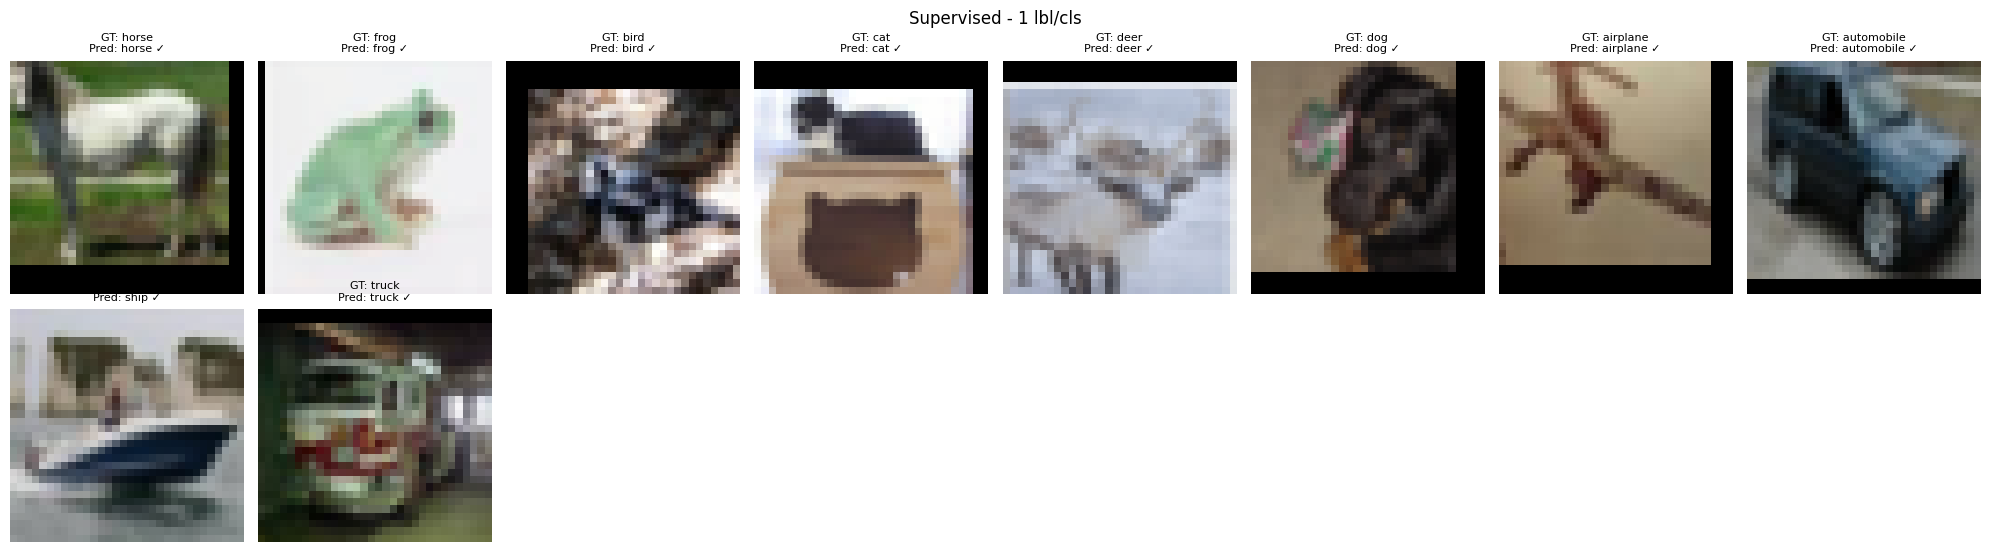

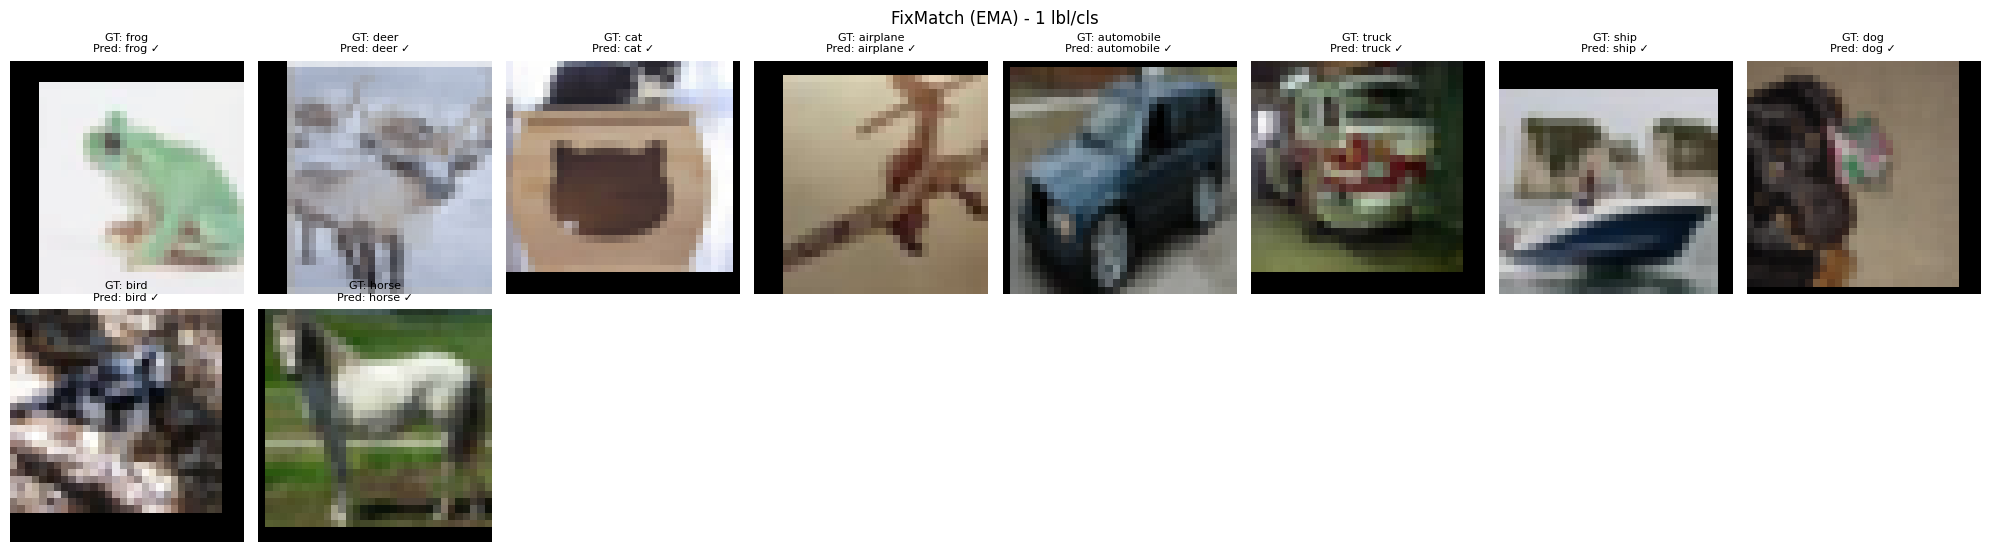

Distribuição de pseudo-rótulos (EMA): [0.06829151 0.00699807 0.06396799 0.15745656 0.14836712 0.14452623
 0.15397763 0.1427767  0.05503941 0.05859878]


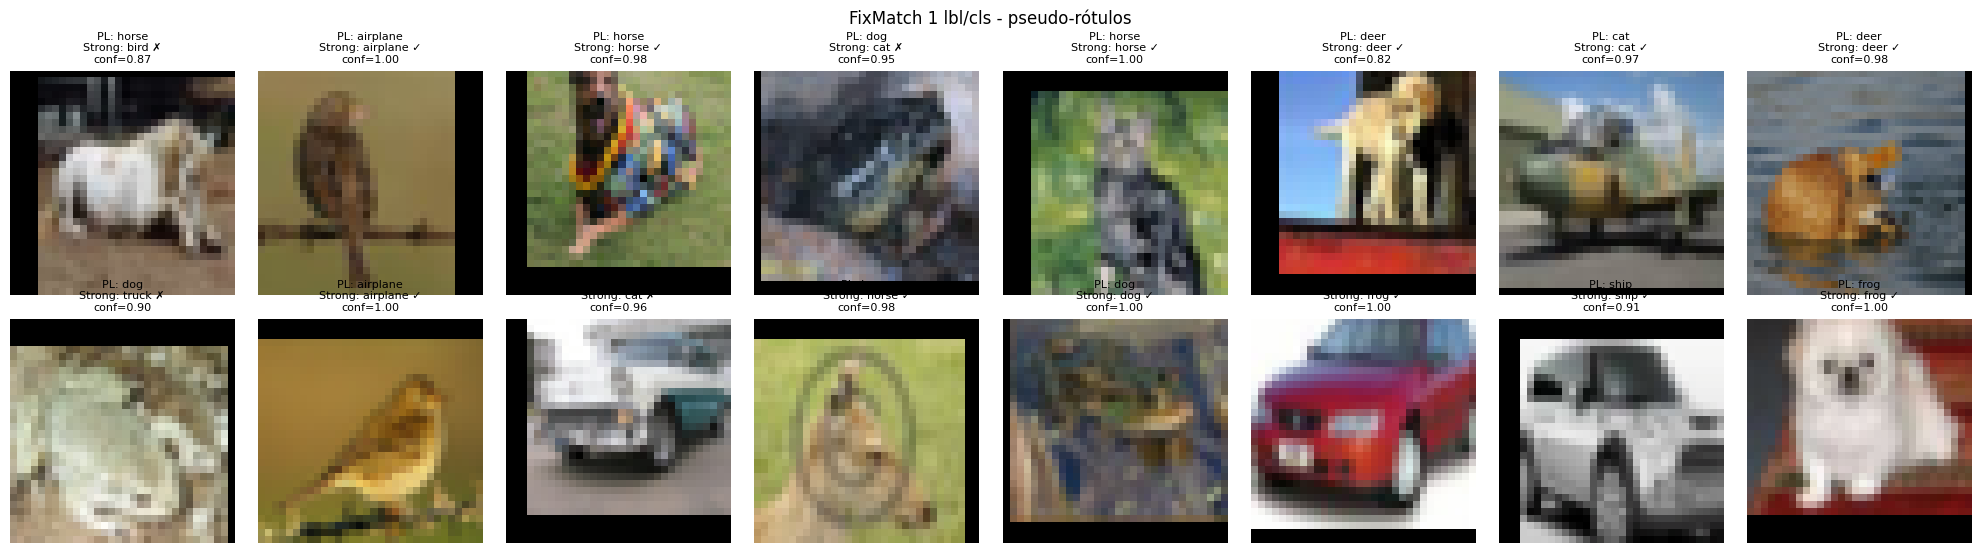

Epoch 1/50 - L_sup: 0.4073 - L_unsup: 0.0000 - L_total: 0.4073 - Mask_cov: 0.000 - EMA Acc: 10.00%
Epoch 2/50 - L_sup: 0.0001 - L_unsup: 0.0000 - L_total: 0.0001 - Mask_cov: 0.000 - EMA Acc: 11.28%
Epoch 3/50 - L_sup: 0.0004 - L_unsup: 0.0268 - L_total: 0.0084 - Mask_cov: 0.025 - EMA Acc: 10.40%
Epoch 4/50 - L_sup: 0.0029 - L_unsup: 0.2232 - L_total: 0.0922 - Mask_cov: 0.432 - EMA Acc: 9.62%
Epoch 5/50 - L_sup: 0.0014 - L_unsup: 0.2202 - L_total: 0.1115 - Mask_cov: 0.568 - EMA Acc: 9.23%
Epoch 6/50 - L_sup: 0.0009 - L_unsup: 0.2005 - L_total: 0.1212 - Mask_cov: 0.491 - EMA Acc: 9.60%
Epoch 7/50 - L_sup: 0.0015 - L_unsup: 0.2043 - L_total: 0.1445 - Mask_cov: 0.447 - EMA Acc: 8.75%
Epoch 8/50 - L_sup: 0.0022 - L_unsup: 0.1088 - L_total: 0.0893 - Mask_cov: 0.329 - EMA Acc: 9.81%
Epoch 9/50 - L_sup: 0.0021 - L_unsup: 0.1176 - L_total: 0.1079 - Mask_cov: 0.344 - EMA Acc: 8.87%
Epoch 10/50 - L_sup: 0.0014 - L_unsup: 0.2302 - L_total: 0.2316 - Mask_cov: 0.474 - EMA Acc: 8.86%
Epoch 11/50 - L_

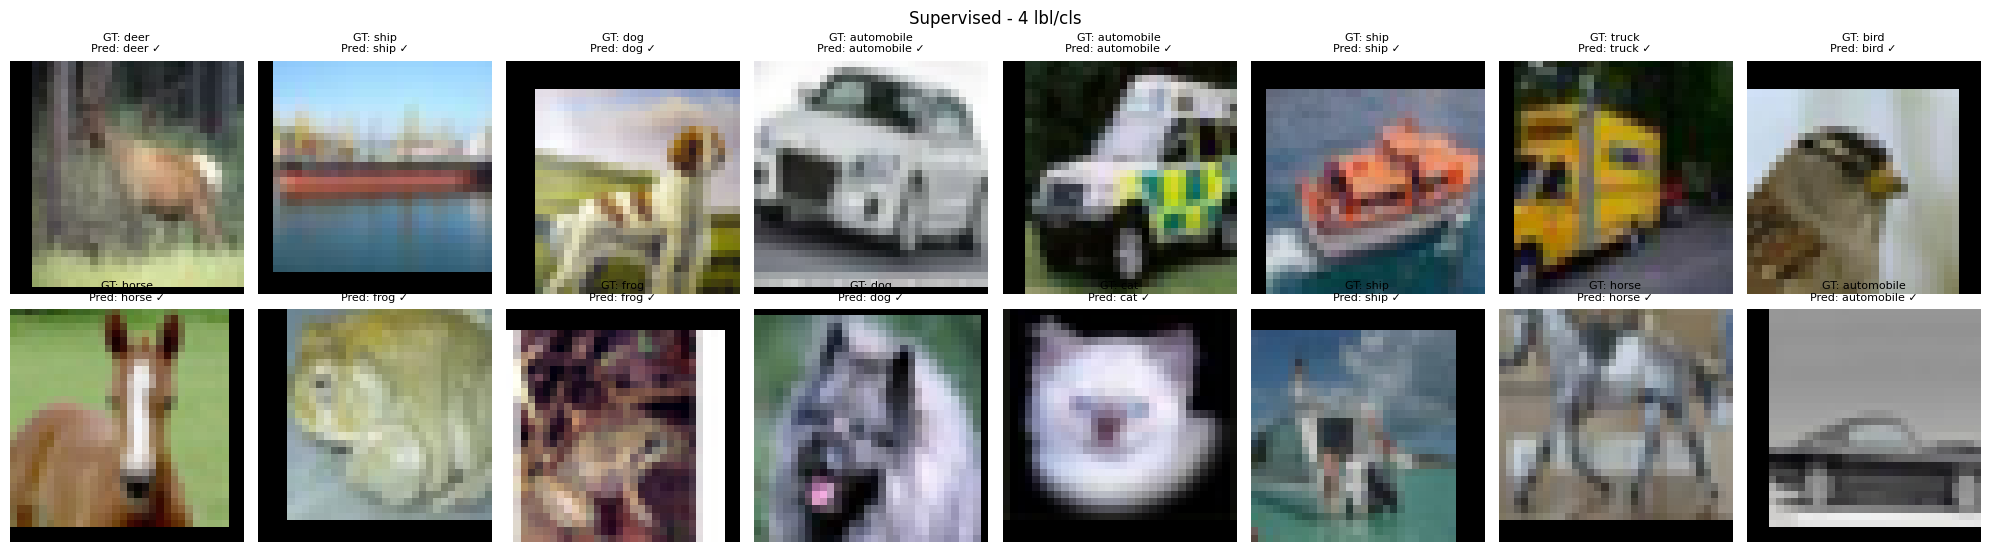

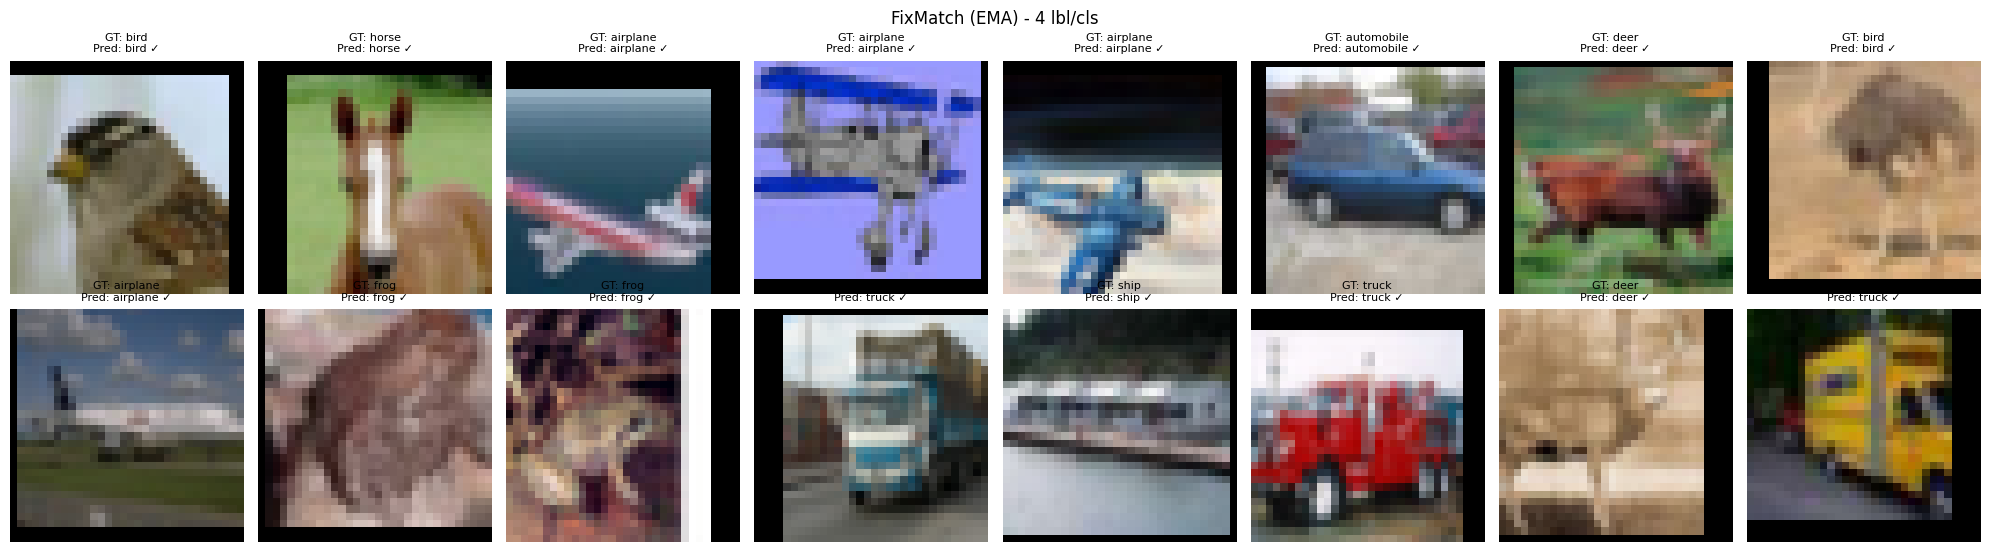

Distribuição de pseudo-rótulos (EMA): [0.12508044 0.0879786  0.09938063 0.09767133 0.11434202 0.04804134
 0.05137951 0.10259813 0.18168838 0.0918396 ]


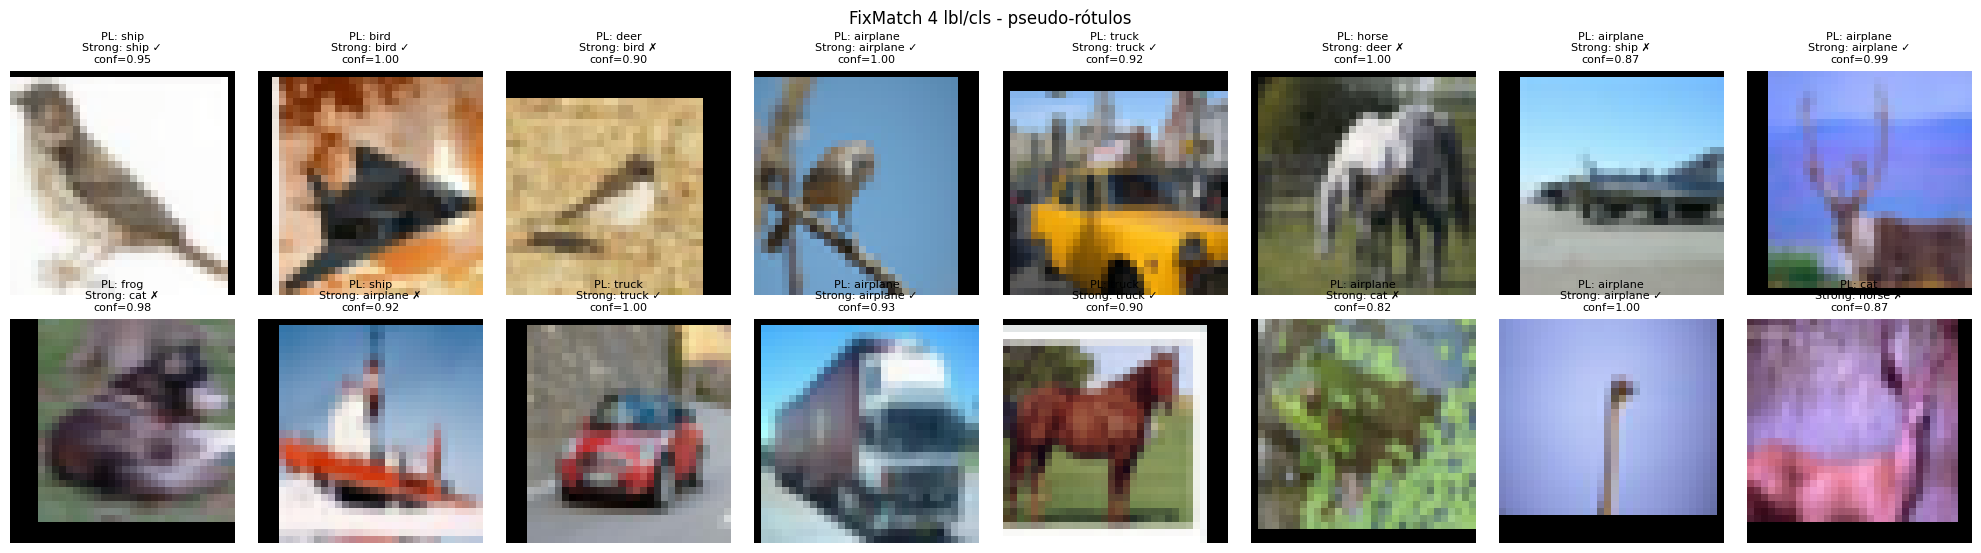

Epoch 1/50 - L_sup: 0.5016 - L_unsup: 0.0000 - L_total: 0.5016 - Mask_cov: 0.000 - EMA Acc: 10.03%
Epoch 2/50 - L_sup: 0.0003 - L_unsup: 0.0008 - L_total: 0.0004 - Mask_cov: 0.000 - EMA Acc: 16.62%
Epoch 3/50 - L_sup: 0.0014 - L_unsup: 0.0506 - L_total: 0.0166 - Mask_cov: 0.051 - EMA Acc: 17.54%
Epoch 4/50 - L_sup: 0.0051 - L_unsup: 0.1832 - L_total: 0.0784 - Mask_cov: 0.458 - EMA Acc: 16.30%
Epoch 5/50 - L_sup: 0.0038 - L_unsup: 0.1846 - L_total: 0.0961 - Mask_cov: 0.536 - EMA Acc: 15.83%
Epoch 6/50 - L_sup: 0.0025 - L_unsup: 0.1310 - L_total: 0.0811 - Mask_cov: 0.466 - EMA Acc: 19.00%
Epoch 7/50 - L_sup: 0.0027 - L_unsup: 0.1795 - L_total: 0.1283 - Mask_cov: 0.342 - EMA Acc: 19.21%
Epoch 8/50 - L_sup: 0.0033 - L_unsup: 0.1863 - L_total: 0.1523 - Mask_cov: 0.355 - EMA Acc: 17.78%
Epoch 9/50 - L_sup: 0.0029 - L_unsup: 0.1530 - L_total: 0.1406 - Mask_cov: 0.323 - EMA Acc: 19.10%
Epoch 10/50 - L_sup: 0.0024 - L_unsup: 0.1523 - L_total: 0.1547 - Mask_cov: 0.357 - EMA Acc: 17.88%
Epoch 11/

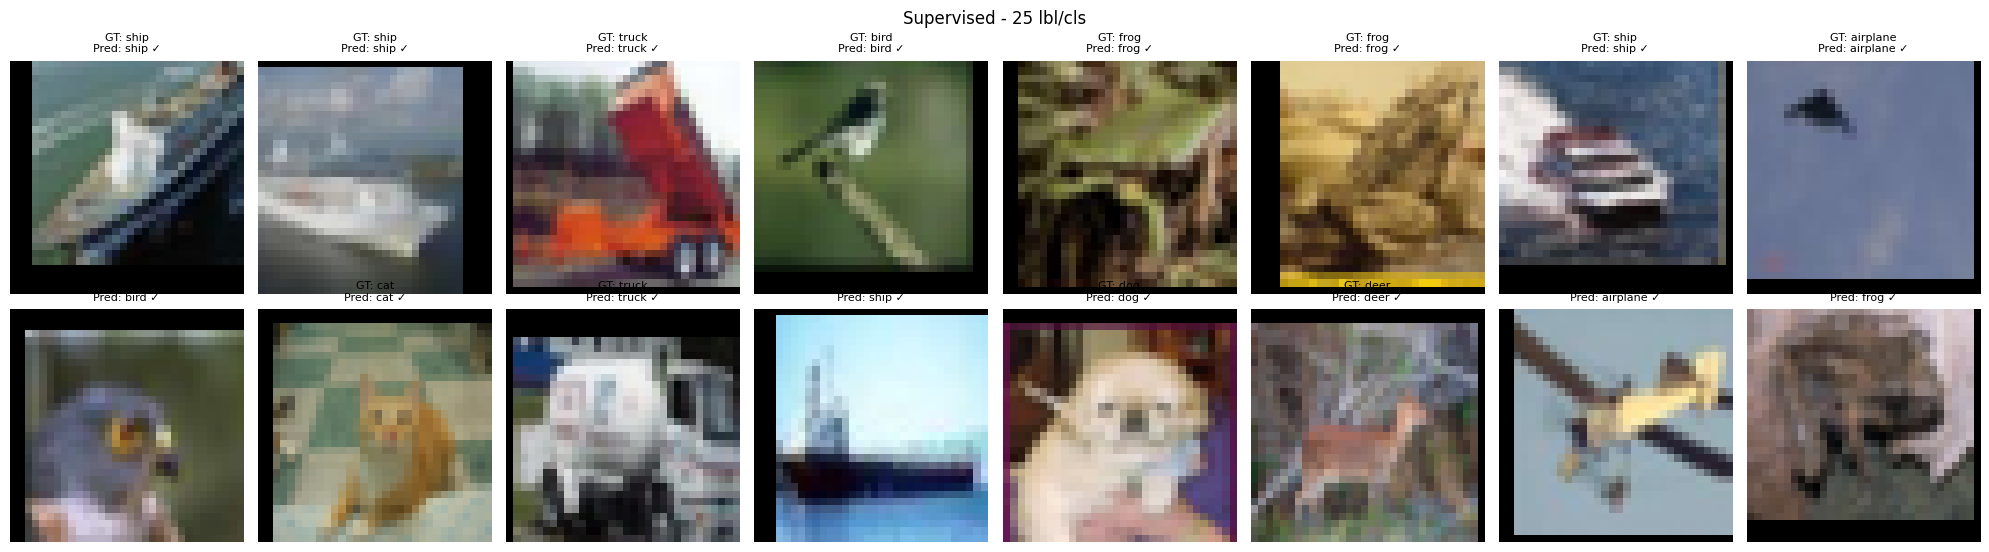

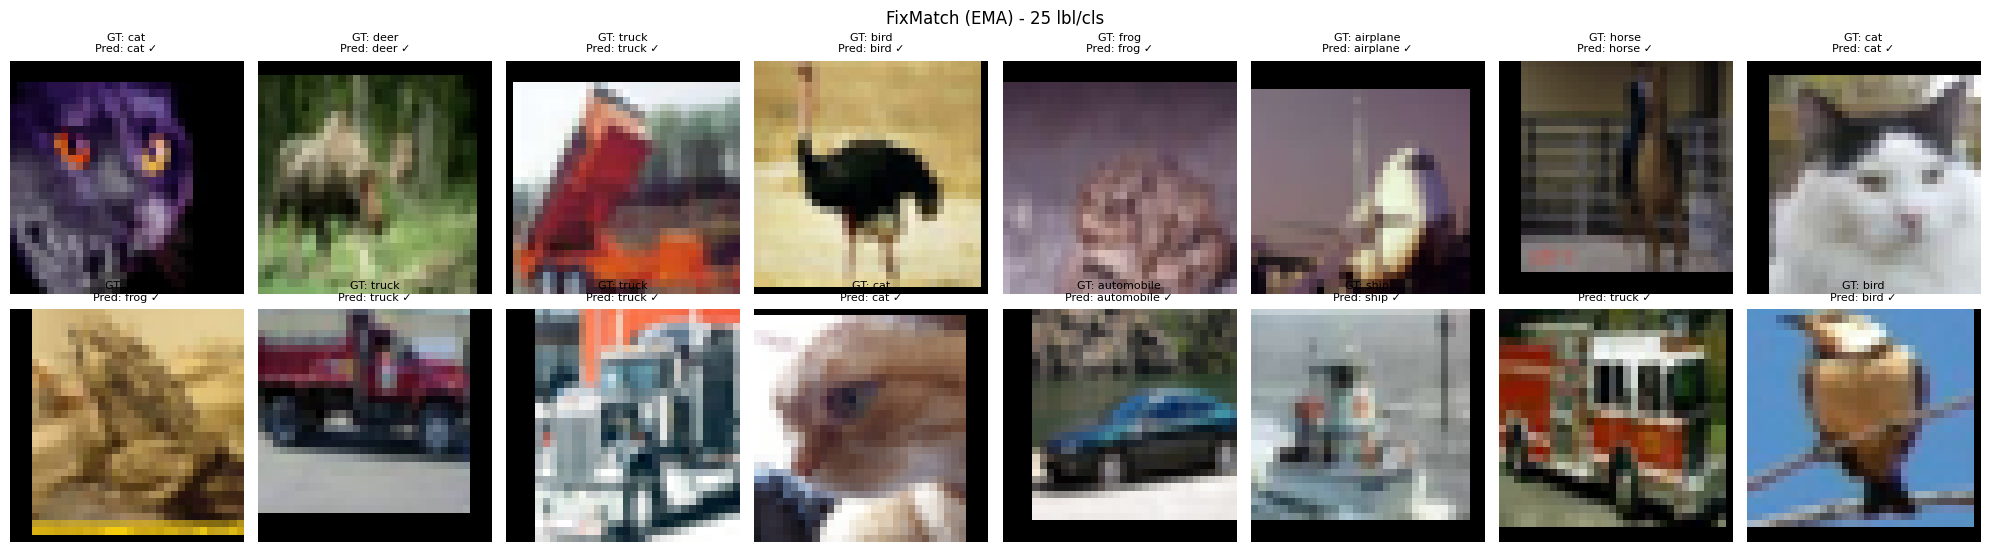

Distribuição de pseudo-rótulos (EMA): [0.11357787 0.09185971 0.0813425  0.13316442 0.08568613 0.06841216
 0.07776303 0.15309283 0.11709701 0.07800435]


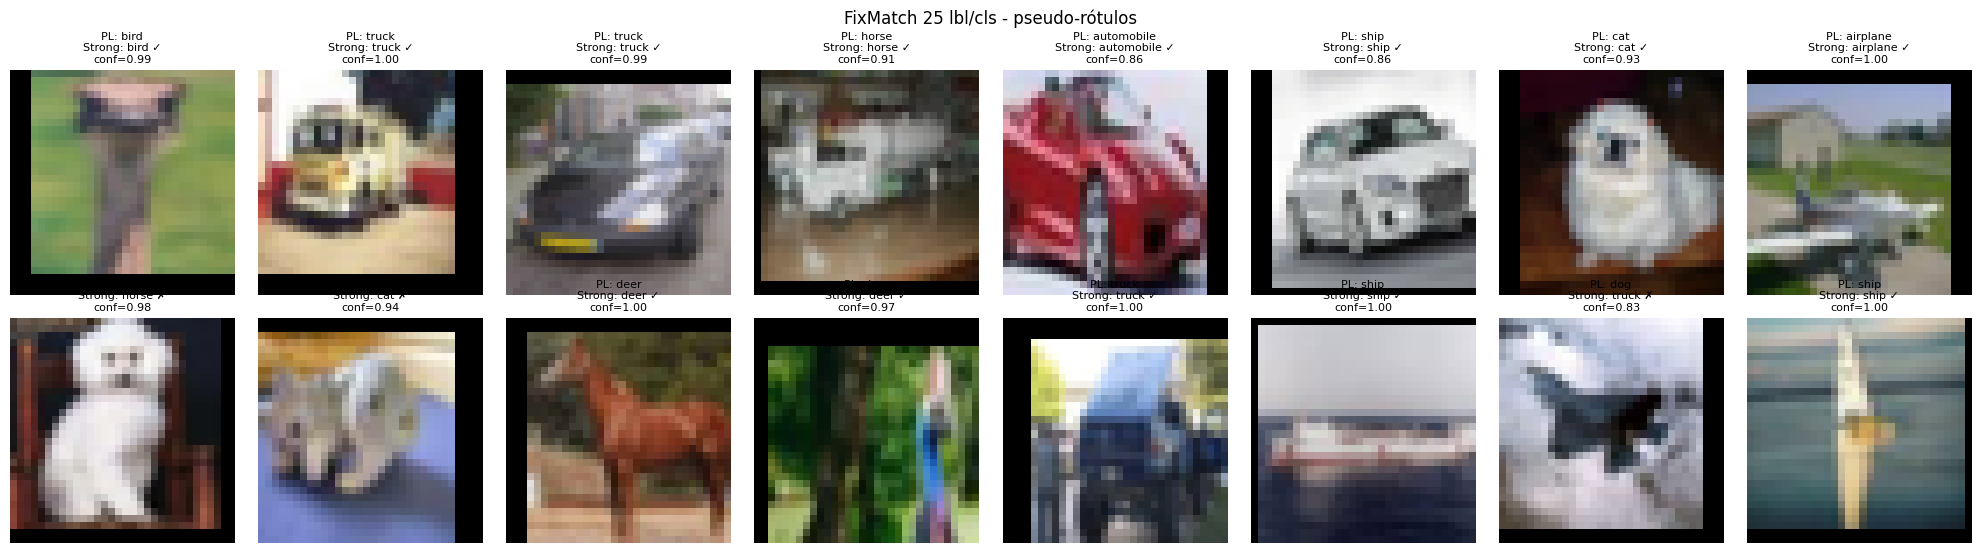

Epoch 1/50 - L_sup: 1.3590 - L_unsup: 0.0000 - L_total: 1.3590 - Mask_cov: 0.000 - EMA Acc: 10.00%
Epoch 2/50 - L_sup: 0.2172 - L_unsup: 0.0000 - L_total: 0.2172 - Mask_cov: 0.000 - EMA Acc: 16.24%
Epoch 3/50 - L_sup: 0.0747 - L_unsup: 0.0174 - L_total: 0.0799 - Mask_cov: 0.010 - EMA Acc: 27.41%
Epoch 4/50 - L_sup: 0.0526 - L_unsup: 0.1090 - L_total: 0.0962 - Mask_cov: 0.168 - EMA Acc: 22.74%
Epoch 5/50 - L_sup: 0.0403 - L_unsup: 0.3184 - L_total: 0.1995 - Mask_cov: 0.367 - EMA Acc: 23.13%
Epoch 6/50 - L_sup: 0.0227 - L_unsup: 0.3486 - L_total: 0.2319 - Mask_cov: 0.506 - EMA Acc: 29.13%
Epoch 7/50 - L_sup: 0.0199 - L_unsup: 0.3471 - L_total: 0.2629 - Mask_cov: 0.515 - EMA Acc: 28.96%
Epoch 8/50 - L_sup: 0.0180 - L_unsup: 0.3367 - L_total: 0.2874 - Mask_cov: 0.488 - EMA Acc: 26.97%
Epoch 9/50 - L_sup: 0.0164 - L_unsup: 0.3313 - L_total: 0.3145 - Mask_cov: 0.659 - EMA Acc: 25.18%
Epoch 10/50 - L_sup: 0.0178 - L_unsup: 0.3057 - L_total: 0.3235 - Mask_cov: 0.571 - EMA Acc: 27.41%
Epoch 11/

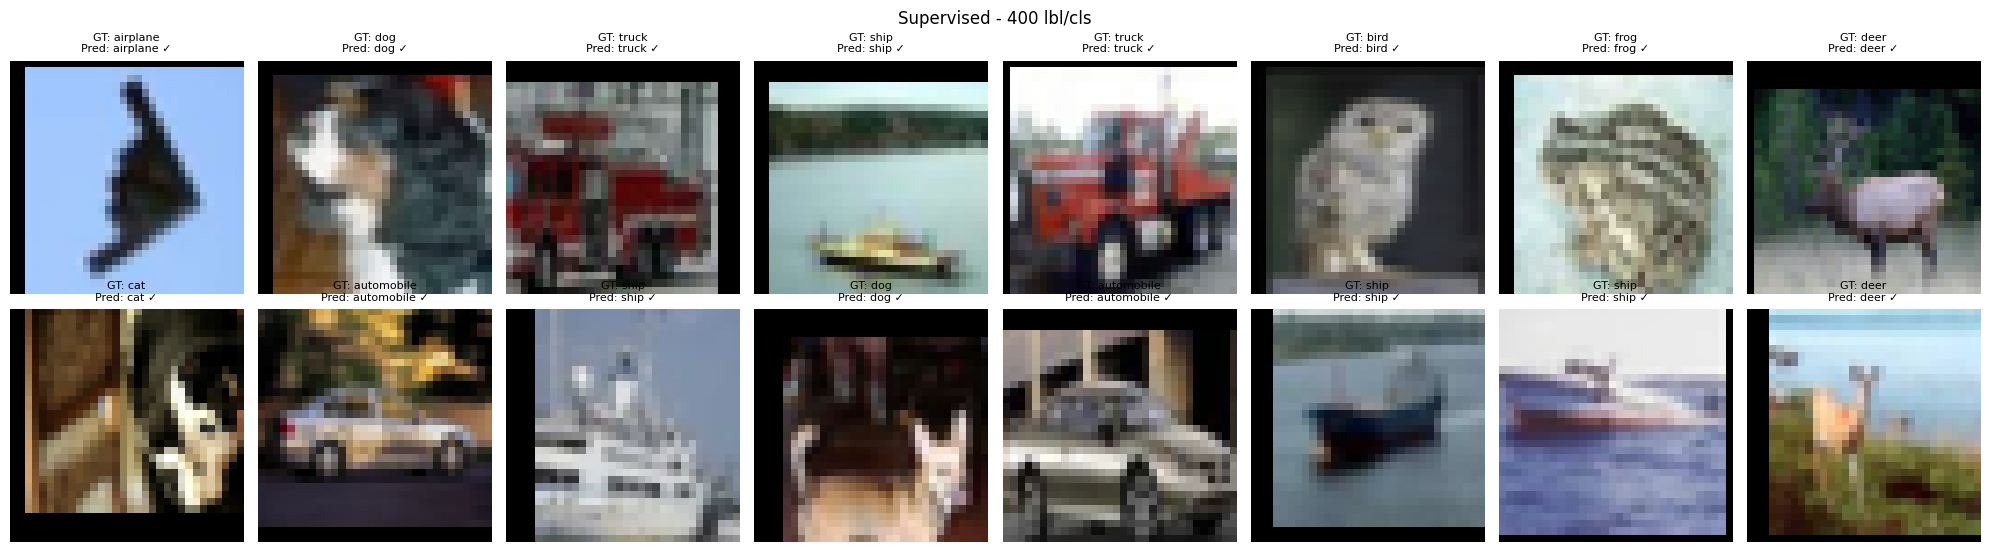

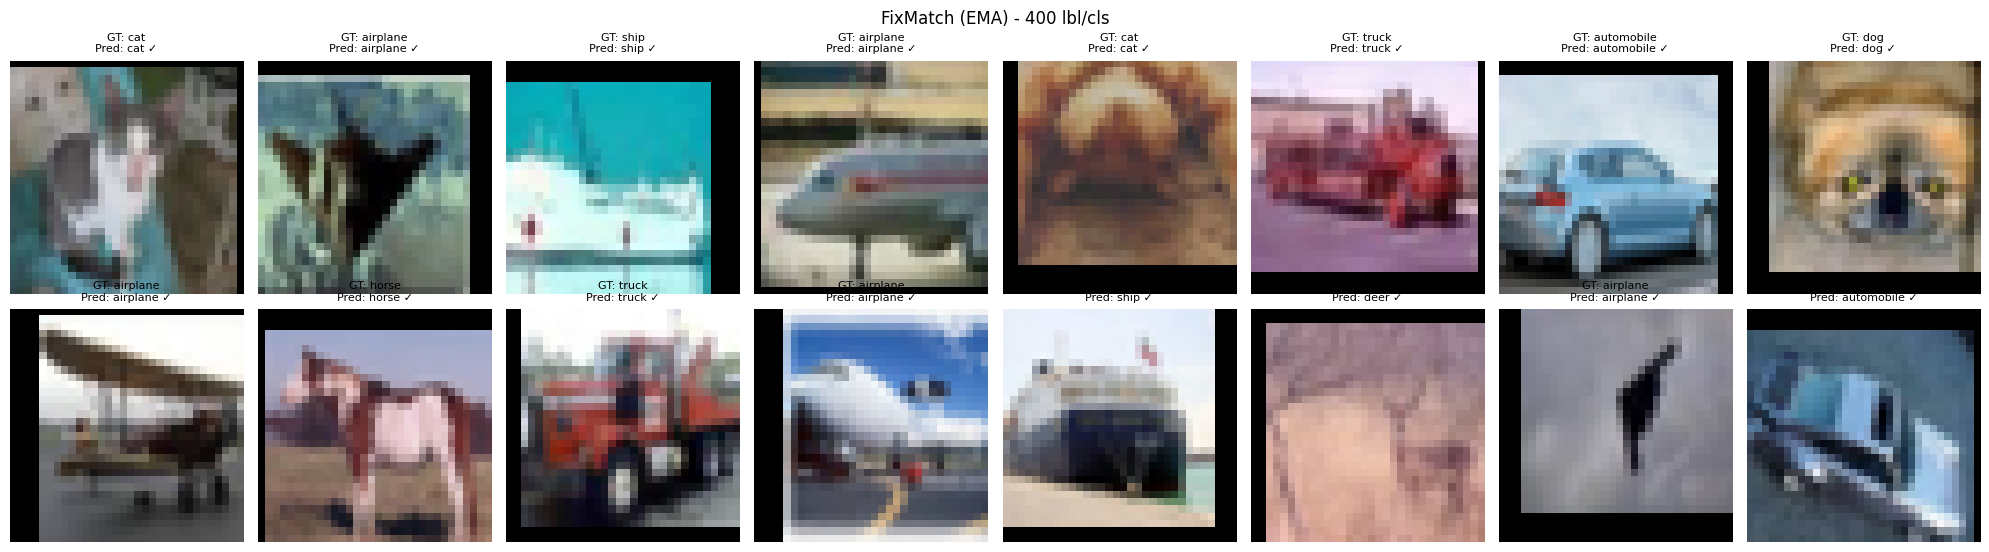

Distribuição de pseudo-rótulos (EMA): [0.09807352 0.09849582 0.09972249 0.13803089 0.09745013 0.06125322
 0.09819417 0.1033824  0.09791265 0.10748471]


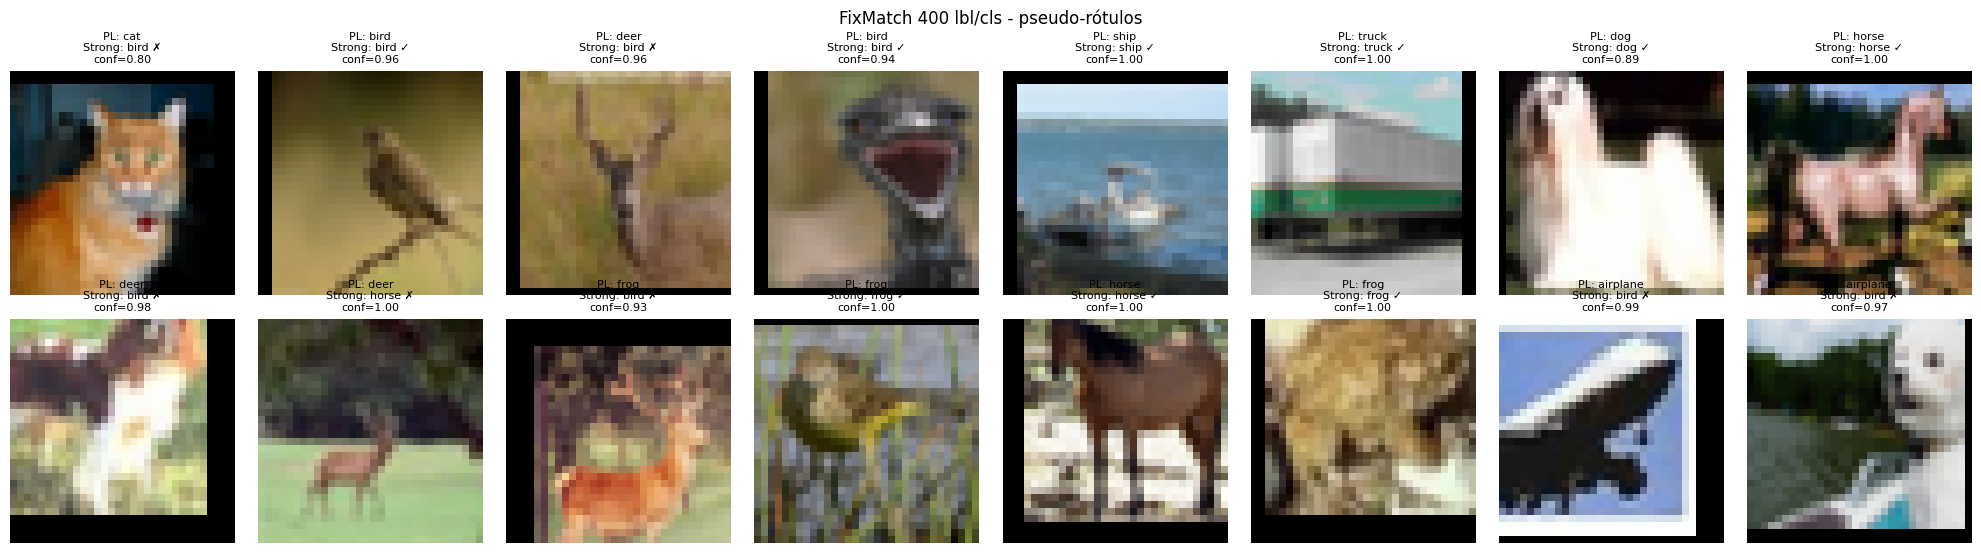

Epoch 1/50 - L_sup: 1.9341 - L_unsup: 0.0000 - L_total: 1.9341 - Mask_cov: 0.000 - EMA Acc: 10.71%
Epoch 2/50 - L_sup: 1.5997 - L_unsup: 0.0000 - L_total: 1.5997 - Mask_cov: 0.000 - EMA Acc: 25.37%
Epoch 3/50 - L_sup: 1.4240 - L_unsup: 0.0000 - L_total: 1.4240 - Mask_cov: 0.000 - EMA Acc: 27.98%
Epoch 4/50 - L_sup: 1.3065 - L_unsup: 0.0000 - L_total: 1.3065 - Mask_cov: 0.000 - EMA Acc: 36.52%
Epoch 5/50 - L_sup: 1.1688 - L_unsup: 0.0023 - L_total: 1.1700 - Mask_cov: 0.003 - EMA Acc: 37.86%
Epoch 6/50 - L_sup: 1.0578 - L_unsup: 0.0315 - L_total: 1.0767 - Mask_cov: 0.046 - EMA Acc: 34.15%
Epoch 7/50 - L_sup: 0.9917 - L_unsup: 0.0638 - L_total: 1.0363 - Mask_cov: 0.114 - EMA Acc: 37.00%
Epoch 8/50 - L_sup: 0.9023 - L_unsup: 0.0772 - L_total: 0.9640 - Mask_cov: 0.138 - EMA Acc: 41.51%
Epoch 9/50 - L_sup: 0.8019 - L_unsup: 0.0792 - L_total: 0.8732 - Mask_cov: 0.152 - EMA Acc: 44.54%
Epoch 10/50 - L_sup: 0.7361 - L_unsup: 0.0714 - L_total: 0.8075 - Mask_cov: 0.147 - EMA Acc: 52.30%
Epoch 11/

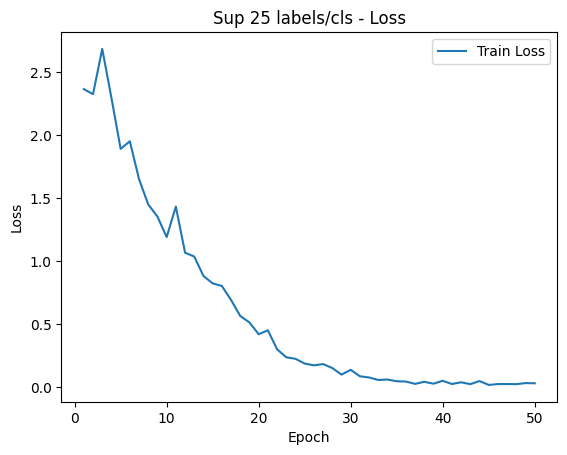

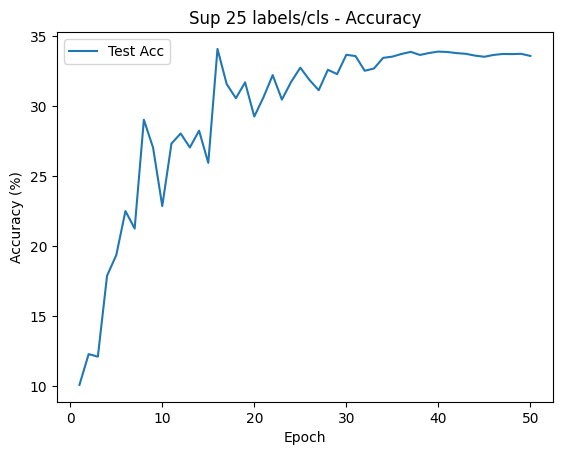

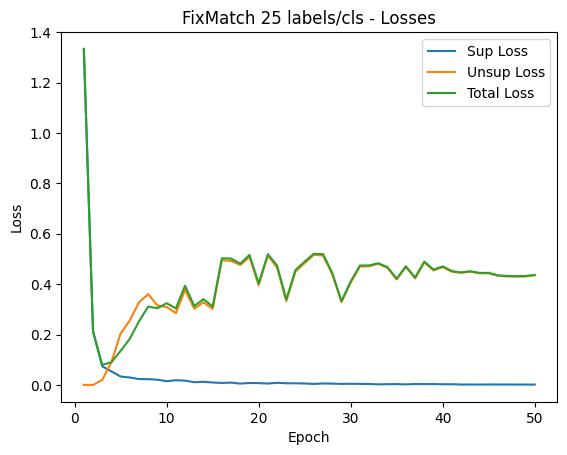

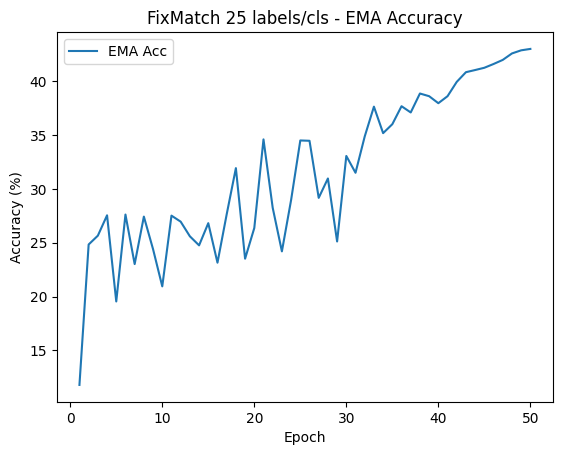

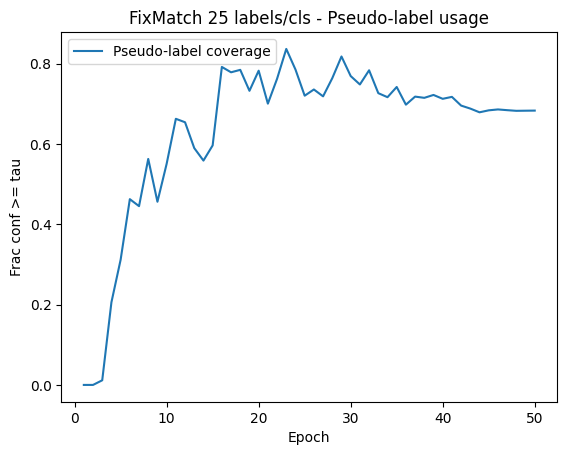

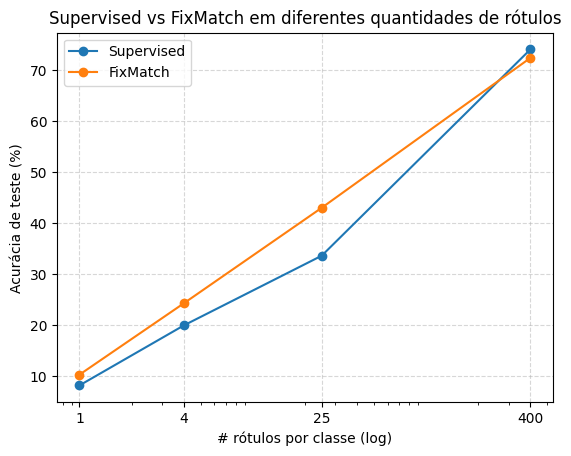

Resumo por # rótulos/classe:
   1 | Sup: 8.12% | FixMatch: 10.23% | Extra: {'fixmatch_tau0.8_acc': 9.33, 'fixmatch_tau0.8_history': {'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'sup_loss': [0.4072879535215671, 6.594603108349654e-05, 0.0003856838569730711, 0.0029378653942347243, 0.0013944866456382966, 0.0009174180232294675, 0.0014673717237242312, 0.00224167377100539, 0.0020522869903010083, 0.0013584289113127812, 0.0011843447576104958, 0.0011623700769190248, 0.000924075222133684, 0.0010149589215870947, 0.000677184572703334, 0.0010697295850289404, 0.0008911339280382743, 0.0008792670681990834, 0.000640974603631368, 0.0005057612500561985, 0.0006025874864208818, 0.00034887440847956603, 0.0004014256076655468, 0.0005961642579620217, 0.00046209865051734906, 0.00038512473301133477, 0.00035904711314271463, 0.0004931444535294111, 0.0004570439

In [ ]:
data_root = "./data"              # onde baixar/ler CIFAR-10
label_budgets = [1, 4, 25, 400]   # rótulos por classe
batch_size = 64
mu = 7                            # fator de não-rotulados (batch_u = batch_size * mu)
num_epochs = 50
seed = 123
extra_test = "lower_tau"          # ou None se não quiser o teste extra


results = run_experiments(
    data_root=data_root,
    label_budgets=tuple(label_budgets),
    batch_size=batch_size,
    mu=mu,
    num_epochs=num_epochs,
    extra_test=extra_test,
    seed=seed,
)
hist_sup = results[25]["supervised_history"]
hist_fm = results[25]["fixmatch_history"]

plot_supervised_history(hist_sup, title="Sup 25 labels/cls")
plot_fixmatch_history(hist_fm, title="FixMatch 25 labels/cls")

plot_overall_accuracy(results)
